In [2]:
from abc import ABC, abstractmethod
from typing import Optional, List, Tuple, Type, Dict
import math

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.axes._axes import Axes

import torch
import torch.nn as nn
import torch.distributions as D
from torch.func import vmap, jacrev
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from tqdm import tqdm
import seaborn as sns
from sklearn.datasets import make_moons, make_circles
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
class Sampleable(ABC):
    @abstractmethod
    def sample(self, num_samples: int) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        pass

In [4]:
class IsotropicGaussian(nn.Module, Sampleable):
    def __init__(self, shape: List[int], std: float = 1.0):
        super().__init__()
        self.shape = shape
        self.std = std
        self.dummy = nn.Buffer(torch.zeros(1))

    def sample(self, num_samples: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.std * torch.randn_like(num_samples, * self.shape).to(self.dummy.device), None

In [5]:
class ConditionalProbabilityPath(nn.Module, ABC):
    def __init__(self, p_simple: Sampleable, p_data: Sampleable):
        super().__init__()
        self.p_simple = p_simple
        self.p_data = p_data

    def sample_marginal_path(self, t: torch.Tensor) -> torch.Tensor:
        """
        t: shape(num_samples, 1, 1, 1)
        returns: x, sampled from p_t(x) shape(num_samples, c, h, w)
        """
        num_samples = t.shape[0]
        # samples z from p(z)
        z, _ = self.sample_conditioning_variable(num_samples) # shape(num_samples, c, h, w)
        # samples x from p_t(x|z)
        x = self.sample_confitional_path(z, t) # shape(nim_samples, c, h, w)
        return x
    
    @abstractmethod
    def sample_conditioning_variable(self, num_samples: int) -> torch.Tensor:
        '''
        Returns:
        - z: (num_samples, c, h, w)
        - y: (num_samples, label_dim)
        '''
        pass

    @abstractmethod
    def sample_conditional_path(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        '''
        z: shape(num_samples, c, h, w), t: shape(num_samples, 1, 1, 1)
        Returns: samples form p_t(x|z)
        - x: (num_samples, c, h, w)
        '''
        pass

    @abstractmethod
    def conditional_vector_field(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        evaluate the conditional velocity u_t(x|z)
        """
        pass

    @abstractmethod
    def conditional_score(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        pass


In [6]:
class Alpha(ABC):
    def __init__(self):
        assert torch.allclose(self(torch.zeros(1, 1, 1, 1)), torch.zeros(1, 1, 1, 1))
        assert torch.allclose(self(torch.ones(1, 1, 1, 1)), torch.ones(1, 1, 1, 1))

    @abstractmethod
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        pass

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        t = t.unsqueeze(1)
        return (vmap(jacrev(self)) (t)).view(-1, 1, 1, 1)
    
class Beta(ABC):
    def __init__(self):
        assert torch.allclose(self(torch.zeros(1, 1, 1, 1)), torch.ones(1, 1, 1, 1))
        assert torch.allclose(self(torch.ones(1, 1, 1, 1)), torch.zeros(1, 1, 1, 1))

    @abstractmethod
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        pass

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        return (vmap(jacrev(self)) (t.unsqueeze(1))).view(-1, 1, 1, 1)
    
class LinearAlpha(Alpha):
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        return t
    
    def dt(self, t: torch.Tensor) -> torch.Tensor:
        return torch.ones_like(t)
    
class LinearBeta(Beta):
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        return 1 - t
    
    def dt(self, t: torch.Tensor) -> torch.Tensor:
        return - torch.ones_like(t)


In [7]:
class GaussianConditionalProbabilityPath(ConditionalProbabilityPath):
    def __init__(self, p_data: Sampleable, p_simple_shape: List[int], alpha: Alpha, beta: Beta):
        p_simple = IsotropicGaussian(p_simple_shape)
        super().__init__(p_simple, p_data)
        self.alpha = alpha
        self.beta = beta

    def sample_conditioning_variable(self, num_samples: int) -> torch.Tensor:
        return self.p_data.sample(num_samples)
    
    def sample_conditional_path(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        return self.alpha(t) * z + self.beta(t) * torch.randn_like(z)
    
    def conditional_vector_field(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        alpha_d = self.alpha.dt(t)
        beta_d = self.beta.dt(t)
        alpha = self.alpha(t)
        beta = self.beta(t)

        return (alpha_d - beta_d * alpha / beta) * z + alpha_d / alpha * x
    
    def conditional_score(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        alpha_t = self.alpha(t)
        beta_t = self.beta(t)
        return (z * alpha_t - x) / beta_t ** 2

In [8]:
class ODE(ABC):
    @abstractmethod
    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor, **kwargs) -> torch.Tensor:
        pass

class SDE(ABC):
    @abstractmethod
    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor, **kwargs) -> torch.Tensor:
        pass

    @abstractmethod
    def diffusion_coefficient(self, xt: torch.Tensor, t: torch.Tensor, **kwargs) -> torch.Tensor:
        pass

In [9]:
class Simulator(ABC):
    @abstractmethod
    def step(self, xt: torch.Tensor, t: torch.Tensor, dt: torch.Tensor, **kwargs):
        pass

    @torch.no_grad()
    def simulate(self, x: torch.Tensor, ts: torch.Tensor, **kwargs):
        """
        Simulates using the discretization gives by ts
        Args:
            - x_init: initial state, shape (bs, c, h, w)
            - ts: timesteps, shape (bs, nts, 1, 1, 1)
        Returns:
            - x_final: final state at time ts[-1], shape (bs, c, h, w)
        """
        nts = ts.shape[1]
        for t_idx in tqdm(range(nts - 1)):
            t = ts[:, t_idx]
            h = ts[:, t_idx + 1] - ts[:, t_idx]
            x = self.step(x, t, h, **kwargs)
        return x

    @torch.no_grad()
    def simulate_with_trajectory(self, x: torch.Tensor, ts: torch.Tensor, **kwargs):
        """
        Simulates using the discretization gives by ts
        Args:
            - x: initial state, shape (bs, c, h, w)
            - ts: timesteps, shape (bs, nts, 1, 1, 1)
        Returns:
            - xs: trajectory of xts over ts, shape (batch_size, nts, c, h, w)
        """
        xs = [x.clone()]
        nts = ts.shape[1]
        for t_idx in tqdm(range(nts - 1)):
            t = ts[:,t_idx]
            h = ts[:, t_idx + 1] - ts[:, t_idx]
            x = self.step(x, t, h, **kwargs)
            xs.append(x.clone())
        return torch.stack(xs, dim=1)

class EulerSimulator(Simulator):
    def __init__(self, ode: ODE):
        self.ode = ode
        
    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor, **kwargs):
        return xt + self.ode.drift_coefficient(xt,t, **kwargs) * h

class EulerMaruyamaSimulator(Simulator):
    def __init__(self, sde: SDE):
        self.sde = sde
        
    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor, **kwargs):
        return xt + self.sde.drift_coefficient(xt,t, **kwargs) * h + self.sde.diffusion_coefficient(xt,t, **kwargs) * torch.sqrt(h) * torch.randn_like(xt)

def record_every(num_timesteps: int, record_every: int) -> torch.Tensor:
    """
    Compute the indices to record in the trajectory given a record_every parameter
    """
    if record_every == 1:
        return torch.arange(num_timesteps)
    return torch.cat(
        [
            torch.arange(0, num_timesteps - 1, record_every),
            torch.tensor([num_timesteps - 1]),
        ]
    )

In [10]:
MiB = 1024 ** 2

def model_size_b(model: nn.Module) -> torch.Tensor:
    size = 0
    for param in model.parameters():
        size += param.nelement() * param.element_size()
    for buf in model.buffers():
        size += buf.nelement() * buf.element_size()
    return size

class Trainer(ABC):
    def __init__(self, model: nn.Module):
        super().__init__()
        self.model = model

    @abstractmethod
    def get_train_loss(self, **kwargs) -> torch.Tensor:
        pass

    def get_optimizer(self, lr: float):
        return torch.optim.Adam(self.model.parameters(), lr=lr)
    
    def train(self, num_epochs: int, device: torch.device, lr: float = 1e-3, **kwargs):
        # print the model size
        size_b = model_size_b(self.model)
        print(f'Training model with size: {size_b / MiB:.3f} MiB')

        # start
        self.model.to(device)
        opt = self.get_optimizer(lr=lr)
        self.model.train()

        # train loop
        pbar = tqdm(enumerate(range(num_epochs)))
        for idx, epoch in pbar:
            opt.zero_grad()
            loss = self.get_train_loss(**kwargs)
            loss.backward()
            opt.step()
            pbar.set_description(f'Epoch {idx}, loss: {loss.item():.3f}')
        
        # finish
        self.model.eval()


In [11]:
class MNISTSampler(nn.Module, Sampleable):
    def __init__(self):
        super().__init__()
        self.dataset = datasets.MNIST(
            root = "./data",
            train=True,
            download=True,
            transform=transforms.Compose([
                transforms.Resize((32, 32)),
                transforms.ToTensor(),
                transforms.Normalize(0.5, 0.5),
            ])
        )
        self.dummy = nn.Buffer(torch.zeros(1))

    def sample(self, num_samples: int) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        if num_samples > len(self.dataset):
            raise ValueError(f"num_samples exceeds dataset size: {len(self.dataset)}")
        
        indices = torch.randperm(len(self.dataset))[:num_samples]
        samples, labels = zip(* [self.dataset[i] for i in indices])
        samples = torch.stack(samples).to(self.dummy.device)
        labels = torch.tensor(labels, dtype=torch.int64).to(self.dummy.device)
        return samples, labels


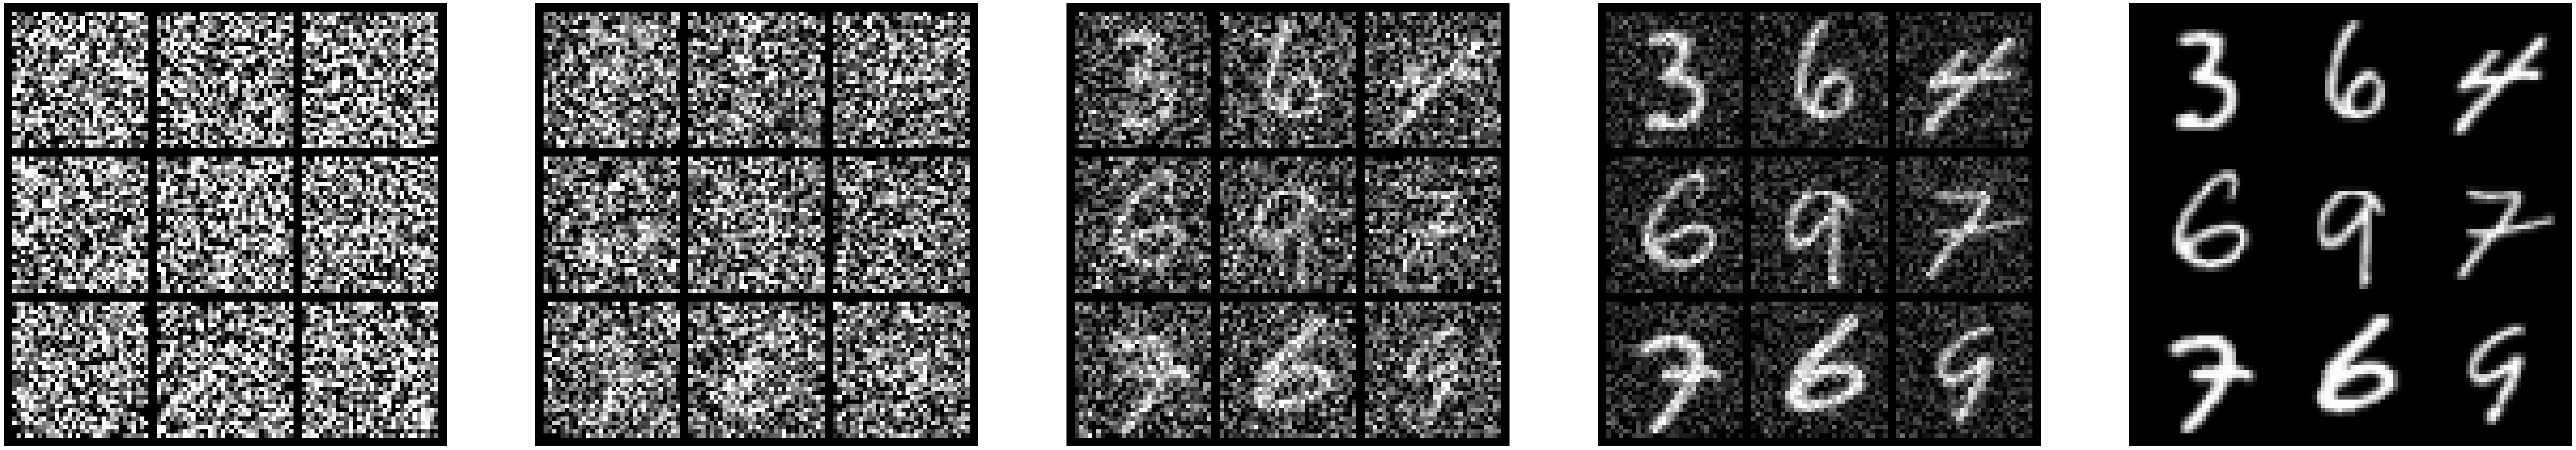

In [12]:
num_rows = 3
num_cols = 3
num_timesteps = 5

sampler = MNISTSampler()

path = GaussianConditionalProbabilityPath(
    p_data = sampler,
    p_simple_shape = [1, 32, 32],
    alpha = LinearAlpha(),
    beta = LinearBeta()
).to(device)

num_samples = num_rows * num_cols
z, _ = path.p_data.sample(num_samples)
z = z.view(-1, 1, 32, 32)

# Setup plot
fig, axes = plt.subplots(1, num_timesteps, figsize=(6 * num_cols * num_timesteps, 6 * num_rows))

# Sample from conditional probability paths and graph
ts = torch.linspace(0, 1, num_timesteps).to(device)
for tidx, t in enumerate(ts):
    tt = t.view(1,1,1,1).expand(num_samples, 1, 1, 1) # (num_samples, 1, 1, 1)
    xt = path.sample_conditional_path(z, tt) # (num_samples, 1, 32, 32)
    grid = make_grid(xt, nrow=num_cols, normalize=True, value_range=(-1,1))
    axes[tidx].imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
    axes[tidx].axis("off")
plt.show()

In [13]:
class ConditionalVectorField(nn.Module, ABC):
    @abstractmethod
    def forward(x: torch.Tensor, t: torch.Tensor, y: torch.Tensor):
        """ 
        returns: u_t^theta(x | y), shape(bs, c, h, w)
        """
        pass

class CFGVectorFieldODE(ODE):
    def __init__(self, net: ConditionalVectorField, guidance_scale: float = 1.0):
        self.net = net
        self.guidance_scale = guidance_scale

    def drift_coefficient(self, x: torch.Tensor, t: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        guided_vector_field = self.net(x, t, y)
        unguided_y = torch.ones_like(x) * 10
        unguided_vector_field = self.net(x, t, unguided_y)
        return (1 - self.guidance_scale) * unguided_vector_field + self.guidance_scale * guided_vector_field

In [14]:
class CFGTrainer(Trainer):
    def __init__(self, path: GaussianConditionalProbabilityPath, model: ConditionalVectorField, eta: float, **kwargs):
        assert eta > 0 and eta < 1
        super().__init__(model, **kwargs)
        self.eta = eta
        self.path = path

    def get_train_loss(self, batch_size: int) -> torch.Tensor:
        # sample (z, y) from the p_data
        z, y = self.path.p_data.sample(batch_size)

        # set all label to 10 with probability eta
        xi = torch.rand(y.shape[0]).to(y.device)
        y[xi < self.eta] = 10.0

        # sample t and x
        t = torch.rand(batch_size, 1, 1, 1, 1).to(z.device)
        x = self.path.sample_conditional_path(z, t)

        # regress and output the loss
        ut_theta = self.model(x, t, y)
        ut_ref = self.path.conditional_vector_field(x, z, t)
        error = torch.einsum('bchw -> b', torch.square(ut_theta = ut_ref))
        return torch.mean(error)
        